# Detectors



In [1]:
%matplotlib inline

In [2]:
from skimage import data
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.cm as cm
from scipy import ndimage,interpolate
from scipy.ndimage.filters import convolve1d

C:\Users\HP\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\HP\AppData\Local\Temp\ipykernel_6272\1502208126.py:8: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve1d


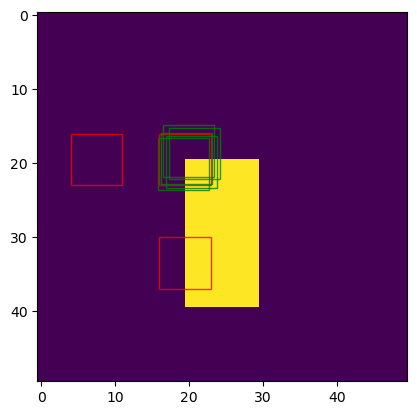

In [3]:
ima = np.zeros((50,50),dtype=np.uint8)
ima[20:40,20:30] = 1

def add_rect(ax,xy,c='r',rand=None): 
    rect = Rectangle(xy,7,7,facecolor="none", edgecolor=c, alpha=0.8)
    ax.add_patch(rect)
    if rand:
        for i in range(5):
            rxy = (xy[0]+rand*np.random.rand()-rand/2,xy[1]+rand*np.random.rand()-rand/2)
            add_rect(ax,rxy,c='g')
    
fig, ax = plt.subplots()
plt.imshow(ima)
add_rect(ax,(16,16),rand=3)
add_rect(ax,(4,16))
add_rect(ax,(16,30))
plt.imshow(ima)
plt.show()

## Harris corner detection

A corner is a point whose local neighborhood stands in two dominant and different edge directions : it can be interpreted as the junction of two edges, an edge being a sudden change in image brightness. Corners are the important features in the image, and they are generally termed as interest points which are invariant to translation, rotation and illumination. Although corners are only a small percentage of the image, they contain the most important features in restoring image information, and they can be used to minimize the amount of processed data for motion tracking, image stitching, building 2D mosaics, stereo vision, image representation and other related computer vision areas. Let's look for corners. Since corners represents a variation in the gradient in the image, we will look for this variation.

Consider a grayscale image $I$. A window $w(x,y)$ is goign to be sweeped, with displacements $u$ in the $x$ direction and $v$ in the $y$ direction. $I$ and $w$ areused to compute the variation of intensity, given by the next equation :
$$
E(u,v) = \displaystyle\sum _{x,y} w(x,y) \ \left[ I(x+u,y+v) - I(x,y) \right]^{2}
$$

where $w(x,y)$ is the window at position $(x,y)$, $I(x,y)$ is the intensity at $(x,y)$, $I(x+u,y+v)$ is the intensity at the moved window $(x+u,y+v)$.Since windows with corners are searched, windows with a large variation in intensity are looked for. Hence, the equation above has to be maximized, specifically the term $\displaystyle\sum _{x,y}[ I(x+u,y+v) - I(x,y)]^{2}$. Using Taylor's expansion of $I(x+u,y+v)$, the following equation is gotten :
$$ 
E(u,v) \approx  \displaystyle\sum _{x,y} w(x,y) \ \left[ I(x,y) + u \ I_{x} + v \ I_{y} - I(x,y) \right]^{2} = \displaystyle\sum _{x,y} w(x,y) \ \left[ + u \ I_{x} + v \ I_{y} \right]^{2}
$$
where $I_{x}$ and $I_{y}$ are x and y image derivatives.

Image derivative can be approximated by discrete differentiation operators, as seen before : $f'(x) = \lim_{h\to0} \frac{f(x+h) - f(x)}{h}$ and for images, the equivallent is given by the convolution of the image $I$  with the Prewitt operator, as shown in the next system.
$$
\begin{cases}
    I_x =
    \begin{bmatrix} 
        +1 & 0 & -1 \\
        +1 & 0 & -1 \\
        +1 & 0 & -1
    \end{bmatrix}
    \ast I \\
    I_y =
    \begin{bmatrix} 
        +1 & +1 & +1 \\
        0 & 0 & 0 \\
    -1 & -1 & -1
    \end{bmatrix}
    \ast I
\end{cases}
$$
Given the former system , the precedent approximation can be expressed in a matrix formulation, as explained by the development below :
$$
\begin{align*}
E(u,v) &\approx \sum _{x,y} w(x,y) \ (u^{2}I_{x}^{2} + 2uvI_{x}I_{y} + v^{2}I_{y}^{2}) \\
&\approx
\begin{bmatrix}
    u & v
\end{bmatrix}
\left( \displaystyle \sum_{x,y} w(x,y) \ 
    \begin{bmatrix} I_x^{2} & I_{x}I_{y}
    \\ I_xI_{y} & I_{y}^{2}
    \end{bmatrix}
\right) \ 
\begin{bmatrix}
    u \\ v
\end{bmatrix} \\
\Rightarrow E(u,v) &\approx
\begin{bmatrix}
    u & v
\end{bmatrix} \ 
M \ 
\begin{bmatrix}
    u \\ v
\end{bmatrix}
\end{align*}
$$
with $M = \displaystyle \sum_{x,y} w(x,y) \ \begin{bmatrix} I_x^{2} & I_{x}I_{y} \\ I_xI_{y} & I_{y}^{2} \end{bmatrix}$. The eigenvalues of the matrix $M$, $\lambda_{1,2}$, have to be computed. Harris suggested to use the following expression in order to speed up the corner detection, instead of explicitely compute $\lambda_{1,2}$ :
$$
R = \det \left( M \right) - k \ \left( trace \left( M \right) \right)^{2}
\label{eq:vector_ray}
$$
where $\det \left( M \right) = \lambda_{1} \cdot \lambda_{2}$, $trace \left( M \right) = \lambda_{1}+\lambda_{2}$ and $k$ is an empirically determined constant, $k \in [0.04,0.06]$. Different cases might happen.
- When $|R|$ is small, which happens when $\lambda_1$ and $\lambda_2$ are small, the region is flat.
- When $R<0$, which happens when $\lambda_1 >> \lambda_2$ or vice versa, the region is an edge.
- When $R$ is large, which happens when $\lambda_1$ and $\lambda_2$ are large and $\lambda_1 \sim \lambda_2$, the region is a corner.

As an alternative to Harris's $R$ simplified formulation, some authors suggested to use another one, the Shi-Tomasi definition, given by the following equation.
$$
R= \min(\lambda_1, \lambda_2)
$$

The following examples illustrate the concept of the Harris corner detection algorithm and something seems clear. Harris corner detection algoritm suffers from a major issue : it is not scale invariant, especially for a discrete image. Thus it depends on the image scale, this problem is taken into account with the two next detectors:
- SIFT : Scale-Invariant Feature Transform,
- SURF : Speeded Up Robust Features.

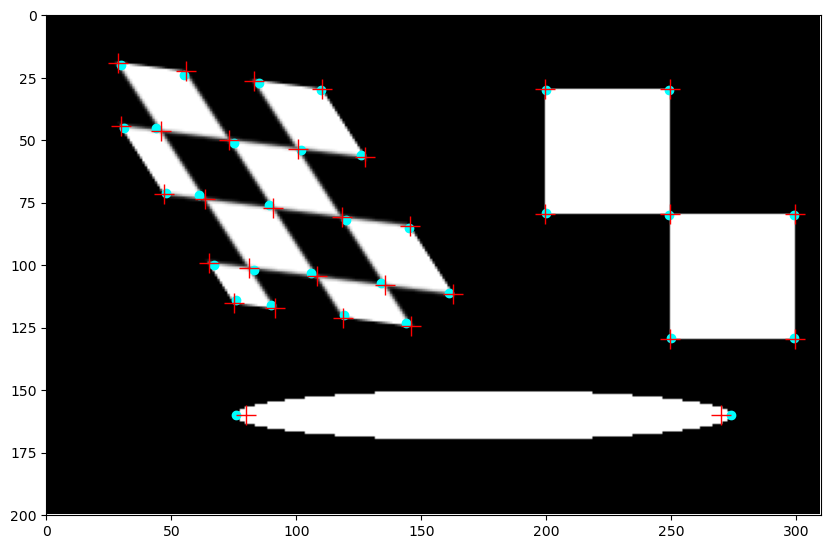

In [4]:
from matplotlib import pyplot as plt

from skimage import data
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform
from skimage.draw import ellipse

# Sheared checkerboard
tform = AffineTransform(scale=(1.3, 1.1), rotation=1, shear=0.7,
                        translation=(110, 30))
image = warp(data.checkerboard()[:90, :90], tform.inverse,
             output_shape=(200, 310))
# Ellipse
rr, cc = ellipse(160, 175, 10, 100)
image[rr, cc] = 1
# Two squares
image[30:80, 200:250] = 1
image[80:130, 250:300] = 1

coords = corner_peaks(corner_harris(image), min_distance=5, threshold_rel=0.02)
coords_subpix = corner_subpix(image, coords, window_size=13)

fig, ax = plt.subplots(figsize=[10,10])
ax.imshow(image, cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
ax.axis((0, 310, 200, 0))
plt.show()



## SIFT (Scale-Invariant Feature Transform)

These are the steps of the SIFT algorithm.
- Computation of the maxima and minima of the **DoG** in the scale space, the latter being obtained by filtering and sub-sampling, hence the building of a pyramid.
- Elimination of the lower contrast points are eliminated (local maximum with 26 neighbours).
- Building of the local orientation signature using the histogram of oriented gradients.

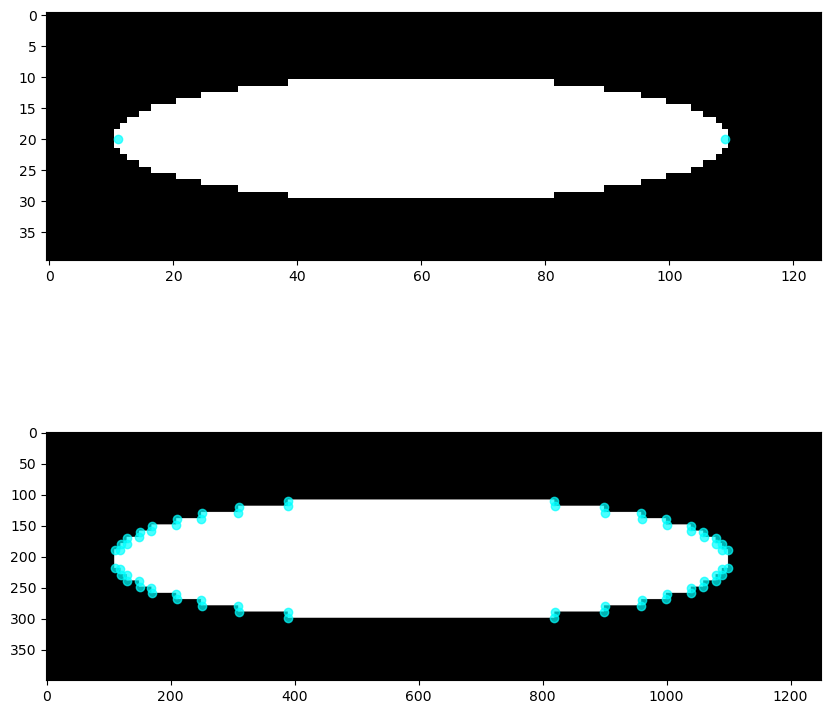

In [5]:
image = np.zeros((40,125),dtype=np.uint8)
rr, cc = ellipse(20, 60, 10, 50)
image[rr, cc] = 1
big_image = cv2.resize(image,(image.shape[1]*10,image.shape[0]*10),interpolation=cv2.INTER_NEAREST)

coords = corner_peaks(corner_harris(image), min_distance=5, threshold_rel=0.04)
big_coords = corner_peaks(corner_harris(big_image), min_distance=5, threshold_rel=0.04)


fig, ax = plt.subplots(2,figsize=[10,10])
ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6,alpha=.7)
ax[1].imshow(big_image, cmap=plt.cm.gray)
ax[1].plot(big_coords[:, 1], big_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6,alpha=.7)
plt.show()

### Pyramid images

Multi-scale approach using pyramidal image decomposition.

C:\Users\HP\AppData\Local\Temp\ipykernel_6272\3942039486.py:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


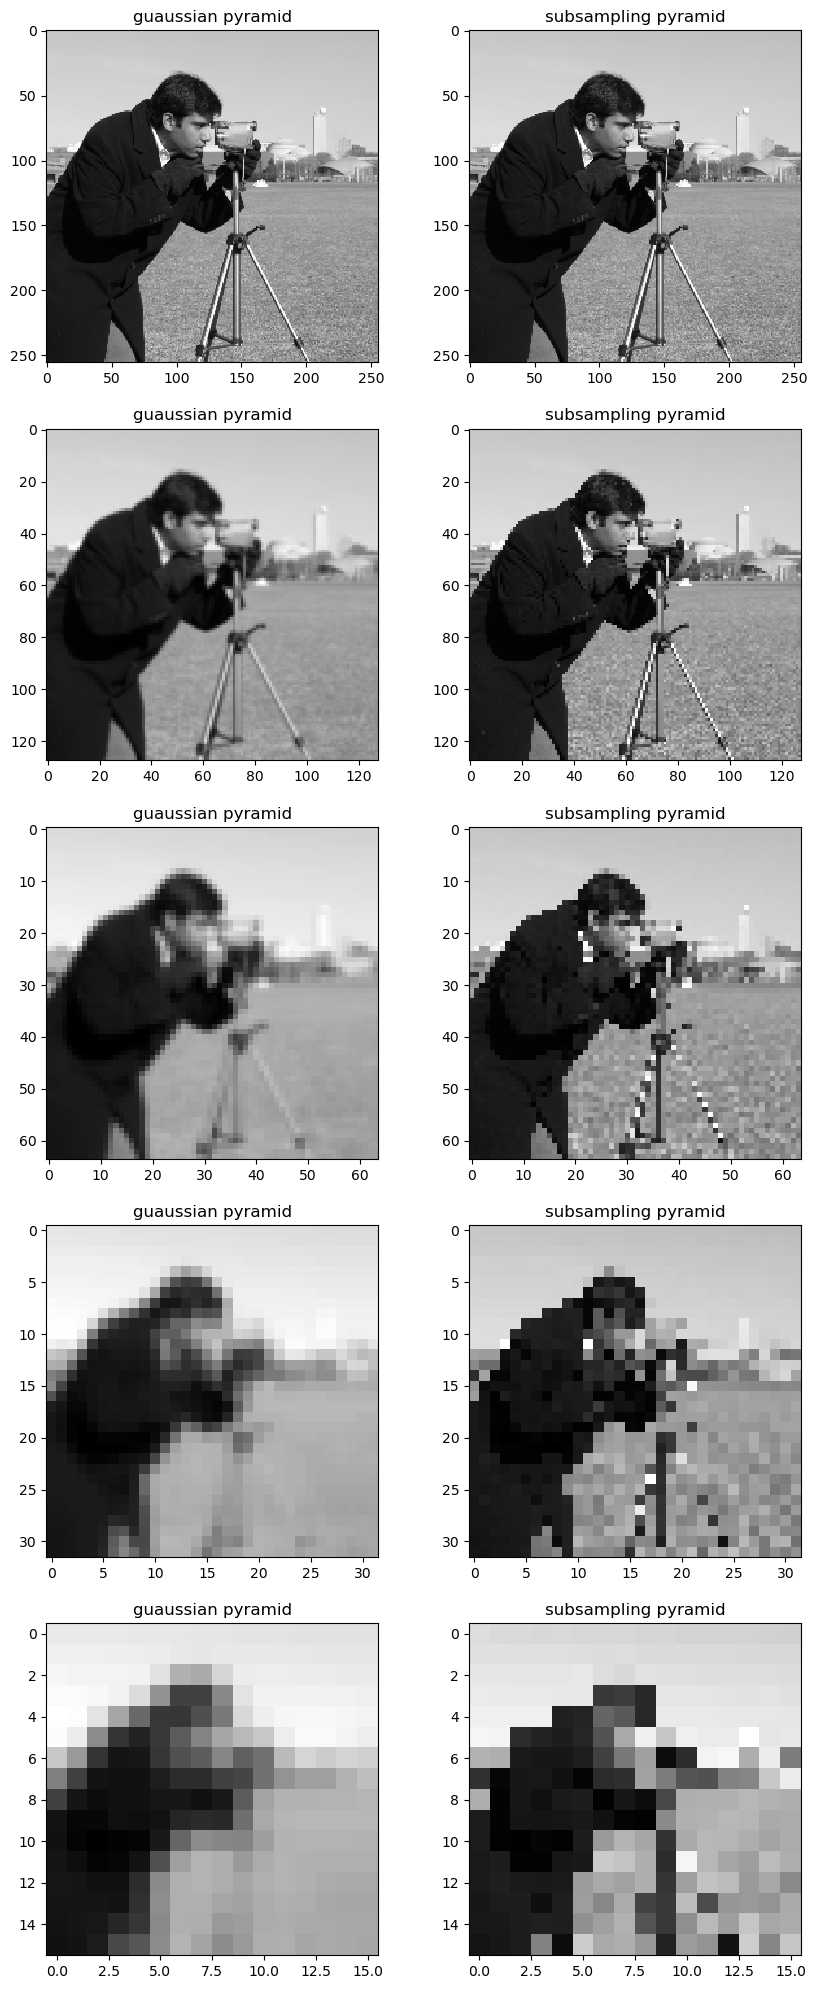

In [6]:
from scipy.ndimage.filters import gaussian_filter
from skimage.data import camera
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def build_gaussian_pyramid(ima,levelmax):
    """return a list of subsampled images (using gaussion pre-filter
    """
    r = [ima]
    current = ima
    for level in range(levelmax):
        lp = gaussian_filter(current,1.0)
        sub = lp[::2,::2]
        current = sub
        r.append(current)
    return r

def build_pyramid(ima,levelmax):
    """return a list of subsampled images (using gaussion pre-filter
    """
    r = [ima]
    current = ima
    for level in range(levelmax):
        sub = current[::2,::2]
        current = sub
        r.append(current)
    return r

im = camera()[::2,::2]

#build filtered and non-filtered pyramids
N = 4
fpyramid = build_gaussian_pyramid(im,N)
nfpyramid = build_pyramid(im,N)

fig, ax = plt.subplots(N+1,2,figsize=[10,25])
                       
for i,(f,nf) in enumerate(zip(fpyramid,nfpyramid)):
    ax[i][0].imshow(f,cmap=plt.cm.gray,interpolation='nearest')
    ax[i][0].set_title('guaussian pyramid')
    ax[i][1].imshow(nf,cmap=plt.cm.gray,interpolation='nearest')
    ax[i][1].set_title('subsampling pyramid');

plt.show()

### Histogram of oriented gradient (HOG)

In order to differentiate each detected corner, local descriptors can be computed. The local gradient orientation distribution can be used. Gradient direction can be computed from local image $x$ and $y$ derivatives, like in the following equation.
$$
\begin{cases}
    I_x =
    \begin{bmatrix} 
        +1 & 0 & -1 \\
    \end{bmatrix}
    \ast \mathbf{I} \\
    I_y =
    \begin{bmatrix} 
        +1 \\
        0  \\
        -1 
    \end{bmatrix}
    \ast \mathbf{I}
\end{cases}
$$
The gradient is then given by $\nabla I(x, y) = \left(I_x, I_y\right)$ with :
- Amplitude : $\sqrt { I_x^2 + I_y^2 }$
- Angle : $\tan^{-1} \left( \frac{I_x}{I_y} \right)$

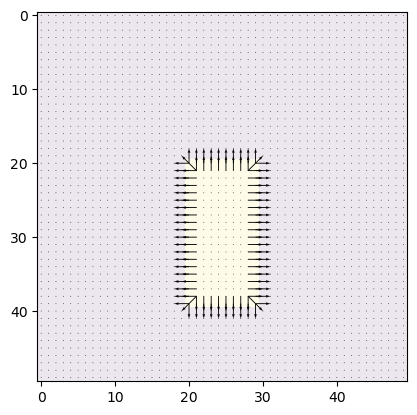

In [7]:
def plot_arrows(z,ax,sub=1):
    
    m,n = z.shape
    x,y = np.meshgrid(range(0,m,sub),range(0,n,sub))
    w = np.array([-1,0,+1])

    dx = convolve1d(z,w,axis=1,origin=0)
    dy = convolve1d(z,w,axis=0,origin=0)

    ax.imshow(z,alpha=.1)
    ax.quiver(x,y,dx[::sub,::sub],dy[::sub,::sub],angles='xy',scale_units='xy', scale=.5, pivot='mid' )

    
    
z = ima.astype(np.int8)

fig, ax = plt.subplots()
plot_arrows(z,ax)
plt.show()

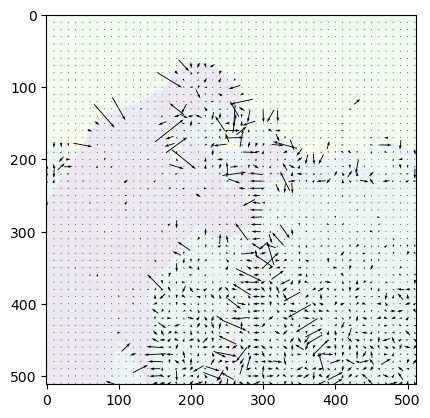

In [8]:
z = data.camera()/10.

fig, ax = plt.subplots()
plot_arrows(z,ax,sub=10)
plt.show()

The local distribution of the gradient direction is a good signature to describe a point of interest.

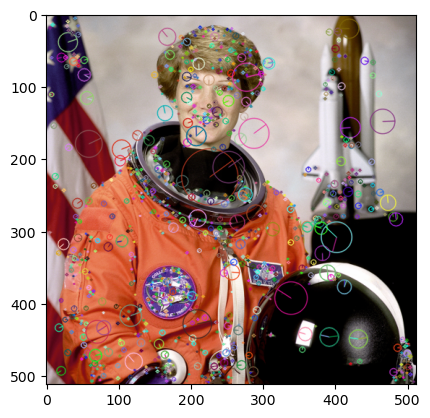

In [9]:
g = data.astronaut()
sift = cv2.SIFT_create()
kp = sift.detect(g,None)
img=cv2.drawKeypoints(g,kp,g,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imsave('astro_points.png',img)
plt.figure()
plt.imshow(img)
plt.show()

## SURF (Speeded Up Robust Features)

In order to speed up the computation of the second derivative of the gaussian, the SURF method uses an approximation : the concept of integral images. An integral image is a data structure for quickly and efficiently generating the sum of values in a rectangular subset of a grid.

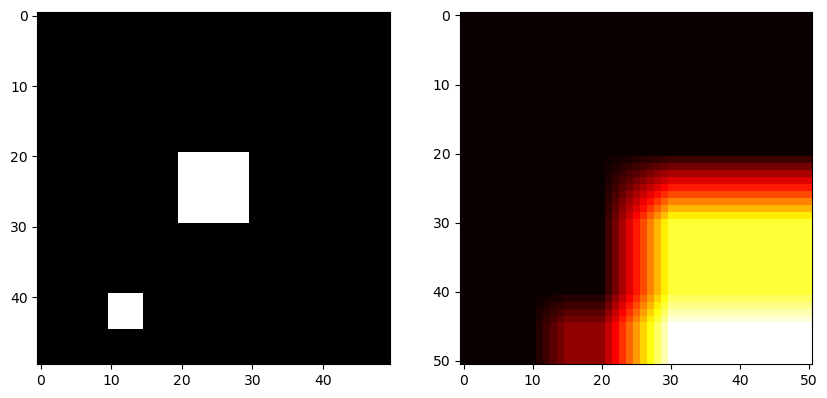

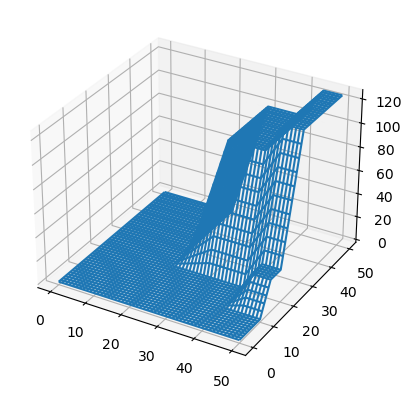

In [11]:
ima = np.zeros((50,50),dtype=np.uint8)
ima[20:30,20:30] = 1
ima[40:45,10:15] = 1
plt.figure(figsize=[10,10])
plt.subplot(1,2,1)
plt.imshow(ima)
integral_image = cv2.integral(ima)
plt.subplot(1,2,2)
plt.imshow(integral_image,cmap=plt.cm.hot)

from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
Z = integral_image
m,n = Z.shape
X, Y = np.mgrid[0:m,0:n]

# Plot a basic wireframe.
ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)


plt.show()

integral = 25, abcd = (0, 0, 25, 0)


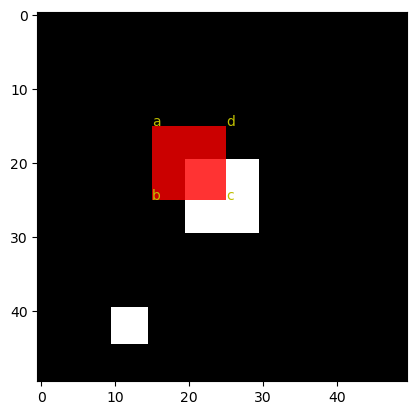

In [12]:
class quad():
    def __init__(self,xy,w,h):
        self.xy = xy
        self.w = w 
        self.h = h
        self.pos_a = (xy[1], xy[0])
        self.pos_b = (xy[1] + h, xy[0])
        self.pos_c = (xy[1] + h, xy[0] + w)
        self.pos_d = (xy[1], xy[0] + w)

    def sample(self,image):
        a = image[self.pos_a]
        b = image[self.pos_b]
        c = image[self.pos_c]
        d = image[self.pos_d]
        return a+c-d-b,(a,b,c,d)
    
    def plot(self,ax,c='r',txt=True):
        rect = Rectangle(self.xy,self.w,self.h,facecolor=c, alpha=0.8)
        ax.add_patch(rect)
        if txt:
            for s,p in zip(['a','b','c','d'],[self.pos_a,self.pos_b,self.pos_c,self.pos_d]):
                ax.text(p[1],p[0],s,c='y')
        
q = quad((15,15),10,10)

fig, ax = plt.subplots()

plt.imshow(ima)
q.plot(ax)
s,abcd = q.sample(integral_image)
print(f'integral = {s}, abcd = {abcd}')

plt.show()


s1: 0, s2: 0


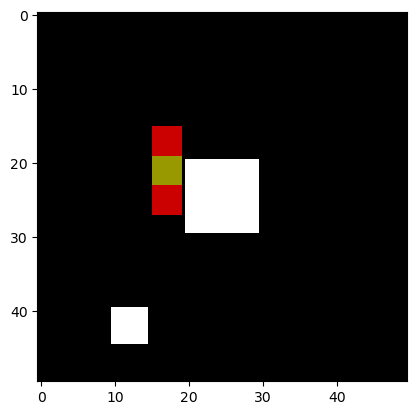

In [13]:
q1 = quad((15,15),4,4)
q2 = quad((15,19),4,4)
q3 = quad((15,23),4,4)

fig, ax = plt.subplots()
plt.imshow(ima)
q1.plot(ax,txt=False)
q2.plot(ax,c='y',txt=False)
q3.plot(ax,txt=False)
s1,_ = q1.sample(integral_image)
s2,_ = q2.sample(integral_image)
print(f's1: {s1}, s2: {s2}')

plt.show()


s1: 0, s2: 0


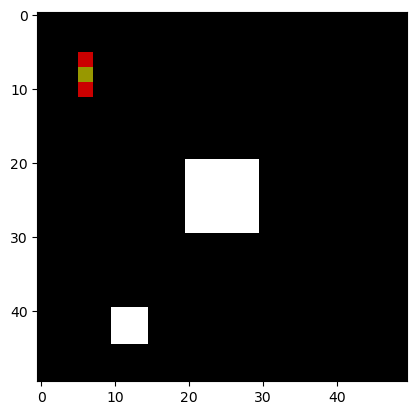

In [14]:
q1 = quad((5,5),2,2)
q2 = quad((5,7),2,2)
q3 = quad((5,9),2,2)

fig, ax = plt.subplots()
plt.imshow(ima)
q1.plot(ax,txt=False)
q2.plot(ax,c='y',txt=False)
q3.plot(ax,txt=False)
s1,_ = q1.sample(integral_image)
s2,_ = q2.sample(integral_image)
print(f's1: {s1}, s2: {s2}')

plt.show()


s1: 0, s2: 0


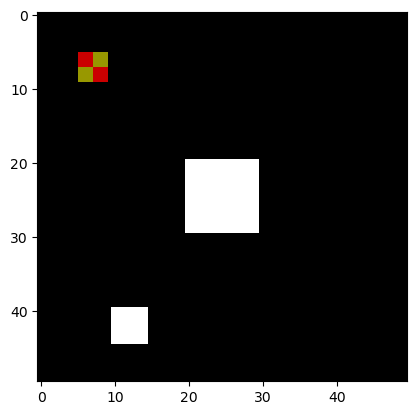

In [15]:
q1 = quad((5,5),2,2)
q2 = quad((5,7),2,2)
q3 = quad((7,7),2,2)
q4 = quad((7,5),2,2)

fig, ax = plt.subplots()
plt.imshow(ima)
q1.plot(ax,txt=False)
q2.plot(ax,c='y',txt=False)
q3.plot(ax,txt=False)
q4.plot(ax,c='y',txt=False)

s1,_ = q1.sample(integral_image)
s2,_ = q2.sample(integral_image)
print(f's1: {s1}, s2: {s2}')

plt.show()


## FAST

<img src="https://upload.wikimedia.org/wikipedia/commons/4/47/FAST_Corner_Detector.jpg">

A pixel $p$ is considered as a corner if one of the two folllowing conditions is met:

* A set of $N$ contiguous pixels $S$, $\forall x \in S$, the intensity of $x$,  $I(x) >  I(p) + t$ 

* A set of $N$ contiguous pixels $S$, $\forall x \in S$, $I(x) < I(p) - t$

> Rosten, E., and T. Drummond. 2005. “Fusing points and lines for high performance tracking.”P. 1508–1515 in Computer Vision, 2005. ICCV 2005. Tenth IEEE International Conference on, vol. 2. IEEE http://ieeexplore.ieee.org/xpls/ abs_all.jsp?arnumber=1544896 (Accessed February 8, 2011).
>
> Rosten, Edward, and Tom Drummond. 2006. “Machine learning for high-speed corner detection.” Computer Vision–ECCV 2006 430–443. http://www.springerlink.com/index/y11g42n05q626127.pdf (Accessed February 8, 2011).

## Application : image warping

from OpenCV examples

Ground truth:
Scale: (0.9000, 0.9000), Translation: (-10.0000, 20.0000), Rotation: -0.2000
Affine transform:
Scale: (0.9015, 0.8913), Translation: (-9.3136, 14.9768), Rotation: -0.1678
RANSAC:
Scale: (0.8999, 0.9001), Translation: (-10.0005, 19.9744), Rotation: -0.1999


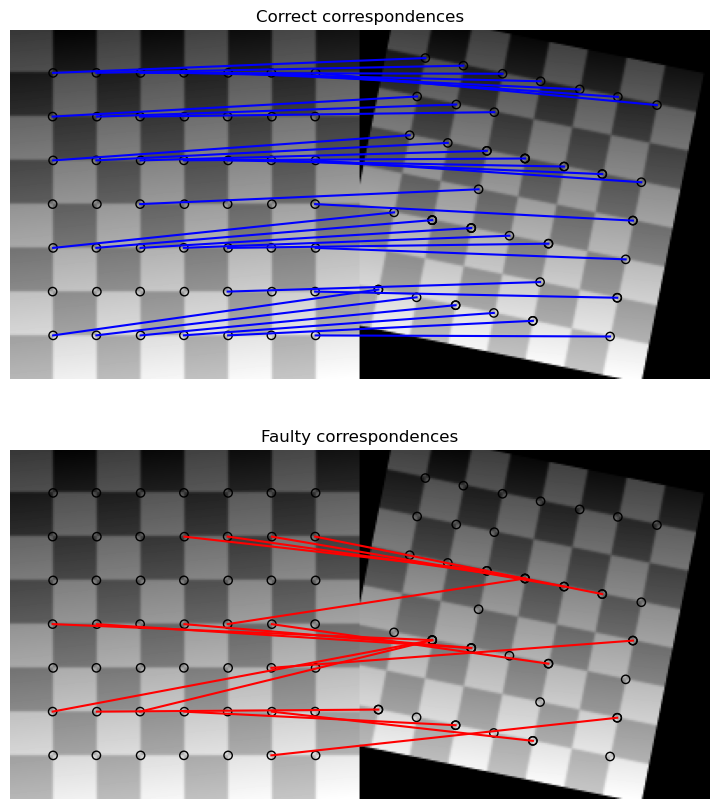

In [10]:
import numpy as np
from matplotlib import pyplot as plt

from skimage import data
from skimage.util import img_as_float
from skimage.feature import (corner_harris, corner_subpix, corner_peaks,
                             plot_matches)
from skimage.transform import warp, AffineTransform
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray
from skimage.measure import ransac


# generate synthetic checkerboard image and add gradient for the later matching
checkerboard = img_as_float(data.checkerboard())
img_orig = np.zeros(list(checkerboard.shape) + [3])
img_orig[..., 0] = checkerboard
gradient_r, gradient_c = (np.mgrid[0:img_orig.shape[0],
                                   0:img_orig.shape[1]]
                          / float(img_orig.shape[0]))
img_orig[..., 1] = gradient_r
img_orig[..., 2] = gradient_c
img_orig = rescale_intensity(img_orig)
img_orig_gray = rgb2gray(img_orig)

# warp synthetic image
tform = AffineTransform(scale=(0.9, 0.9), rotation=0.2, translation=(20, -10))
img_warped = warp(img_orig, tform.inverse, output_shape=(200, 200))
img_warped_gray = rgb2gray(img_warped)

# extract corners using Harris' corner measure
coords_orig = corner_peaks(corner_harris(img_orig_gray), threshold_rel=0.001,
                           min_distance=5)
coords_warped = corner_peaks(corner_harris(img_warped_gray),
                             threshold_rel=0.001, min_distance=5)

# determine sub-pixel corner position
coords_orig_subpix = corner_subpix(img_orig_gray, coords_orig, window_size=9)
coords_warped_subpix = corner_subpix(img_warped_gray, coords_warped,
                                     window_size=9)


def gaussian_weights(window_ext, sigma=1):
    y, x = np.mgrid[-window_ext:window_ext+1, -window_ext:window_ext+1]
    g = np.zeros(y.shape, dtype=np.double)
    g[:] = np.exp(-0.5 * (x**2 / sigma**2 + y**2 / sigma**2))
    g /= 2 * np.pi * sigma * sigma
    return g


def match_corner(coord, window_ext=5):
    r, c = np.round(coord).astype(np.intp)
    window_orig = img_orig[r-window_ext:r+window_ext+1,
                           c-window_ext:c+window_ext+1, :]

    # weight pixels depending on distance to center pixel
    weights = gaussian_weights(window_ext, 3)
    weights = np.dstack((weights, weights, weights))

    # compute sum of squared differences to all corners in warped image
    SSDs = []
    for cr, cc in coords_warped:
        window_warped = img_warped[cr-window_ext:cr+window_ext+1,
                                   cc-window_ext:cc+window_ext+1, :]
        SSD = np.sum(weights * (window_orig - window_warped)**2)
        SSDs.append(SSD)

    # use corner with minimum SSD as correspondence
    min_idx = np.argmin(SSDs)
    return coords_warped_subpix[min_idx]


# find correspondences using simple weighted sum of squared differences
src = []
dst = []
for coord in coords_orig_subpix:
    src.append(coord)
    dst.append(match_corner(coord))
src = np.array(src)
dst = np.array(dst)


# estimate affine transform model using all coordinates
model = AffineTransform()
model.estimate(src, dst)

# robustly estimate affine transform model with RANSAC
model_robust, inliers = ransac((src, dst), AffineTransform, min_samples=3,
                               residual_threshold=2, max_trials=100)
outliers = inliers == False


# compare "true" and estimated transform parameters
print("Ground truth:")
print(f'Scale: ({tform.scale[1]:.4f}, {tform.scale[0]:.4f}), '
      f'Translation: ({tform.translation[1]:.4f}, '
      f'{tform.translation[0]:.4f}), '
      f'Rotation: {-tform.rotation:.4f}')
print("Affine transform:")
print(f'Scale: ({model.scale[0]:.4f}, {model.scale[1]:.4f}), '
      f'Translation: ({model.translation[0]:.4f}, '
      f'{model.translation[1]:.4f}), '
      f'Rotation: {model.rotation:.4f}')
print("RANSAC:")
print(f'Scale: ({model_robust.scale[0]:.4f}, {model_robust.scale[1]:.4f}), '
      f'Translation: ({model_robust.translation[0]:.4f}, '
      f'{model_robust.translation[1]:.4f}), '
      f'Rotation: {model_robust.rotation:.4f}')

# visualize correspondence
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=[10,10])

plt.gray()

inlier_idxs = np.nonzero(inliers)[0]
plot_matches(ax[0], img_orig_gray, img_warped_gray, src, dst,
             np.column_stack((inlier_idxs, inlier_idxs)), matches_color='b')
ax[0].axis('off')
ax[0].set_title('Correct correspondences')

outlier_idxs = np.nonzero(outliers)[0]
plot_matches(ax[1], img_orig_gray, img_warped_gray, src, dst,
             np.column_stack((outlier_idxs, outlier_idxs)), matches_color='r')
ax[1].axis('off')
ax[1].set_title('Faulty correspondences')

plt.show()